In [240]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import scipy

import warnings
warnings.filterwarnings('ignore')

In [241]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Leica confocal/'
protein="TNR" #TNR,Agg,WFA,HABP

In [106]:
results = {"filename":[],
          "exp condition":[],
          "ecmchannelno":[],
          "endosomechannelno":[],
           "Manual ECM spots mask":[],
           "Manual endosome spots mask":[],
          }
           
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if "_analyse" in str(filelist[i]):
        if "2019" in str(filelist[i]):
            if ("posthoc" in str(filelist[i]))==False:
                #if (protein in str(filelist[i]))==True:
                    if filelist[i].endswith(".tif"): 
                        if str(filelist[i][:-12]) not in str(results["filename"]):
                            results["filename"].append(filelist[i][:-12])
                            results["exp condition"].append(filelist[i][:-12].split('/')[-2])
                            channeldir="/".join(filelist[i][:-12].split("/")[:-1])
                            exec(open(channeldir+"/channels.txt").read())
                            results["ecmchannelno"].append(ecmchannelno)
                            results["endosomechannelno"].append(endosomechannelno)
                                        

## Loading a random image

ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: 20190522_negctrl_tnrstar580_achtatto647_Series3_z
Experimental condition: 20190522_negctrl_tnrstar580_achtatto647


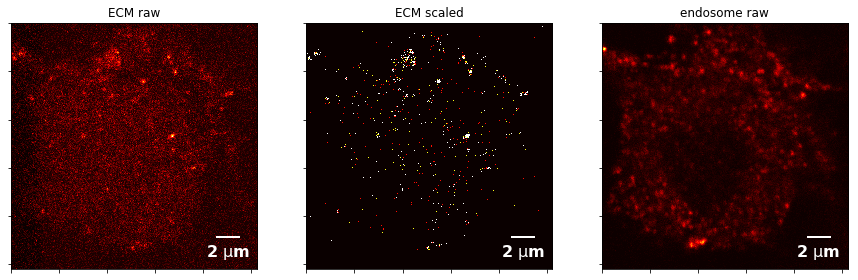

In [107]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
endosome_channel_no=results["endosomechannelno"][randomno]

ecm_image_name=results["filename"][randomno]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
endosome_image_name=results["filename"][randomno]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"

print("Image name:",results["filename"][randomno].split('/')[-1])
print("Experimental condition:",results["exp condition"][randomno])
ecm_image=pims.open(ecm_image_name)[0]
endosome_image=pims.open(endosome_image_name)[0]
   
figure=plt.figure(figsize=(15,15))
figure.add_subplot(131)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
figure.add_subplot(132)
plt.imshow(ecm_image,interpolation='none',cmap='hot',vmin=3*np.min(ecm_image),vmax=0.4*np.max(ecm_image))
plt.title('ECM scaled')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

figure.add_subplot(133)
plt.imshow(endosome_image,interpolation='none',cmap='hot')
plt.title('endosome raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

## Load manual spots

In [108]:
for image in range(0,len(results["filename"])):
    results["Manual ECM spots mask"].append(np.load(results["filename"][image]+'_ecm_spots_mask.npy'))
    results["Manual endosome spots mask"].append(np.load(results["filename"][image]+'_endosome_spots_mask.npy'))

### Sanity check

In [ ]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
endosome_channel_no=results["endosomechannelno"][randomno]

ecm_image_name=results["filename"][randomno]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
endosome_image_name=results["filename"][randomno]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"

ecm_image=pims.open(ecm_image_name)[0]
endosome_image=pims.open(endosome_image_name)[0]

#read spots masks and label
ecm_mask=results["Manual ECM spots mask"][randomno]
endosome_mask=results["Manual endosome spots mask"][randomno]
#rotated ecm mask
rot_ecm_mask=deepcopy(ecm_mask)
rot_ecm_mask=np.rot90(rot_ecm_mask)
labeled_ecm=label(ecm_mask)
rot_labeled_ecm=label(rot_ecm_mask)
labeled_endosome=label(endosome_mask)

regionprops_ecm=regionprops(labeled_ecm)
regionprops_endosome=regionprops(labeled_endosome)
rot_regionprops_ecm=regionprops(rot_labeled_ecm)

ecm_spots_results_sanity=[]
rot_ecm_spots_results_sanity=[]
endosome_spots_results_sanity=[]
for i in range(0,len(regionprops_ecm)):
    ecm_spots_results_sanity.append(regionprops_ecm[i]['centroid'])
for i in range(0,len(rot_regionprops_ecm)):
    rot_ecm_spots_results_sanity.append(rot_regionprops_ecm[i]['centroid'])
for i in range(0,len(regionprops_endosome)):
    endosome_spots_results_sanity.append(regionprops_endosome[i]['coords'])

#minimum distance between spots
distances=[]
rot_distances=[]
for blob in range(0,len(endosome_spots_results_sanity)):
    distances.append(scipy.spatial.distance.cdist
                     (np.round(ecm_spots_results_sanity),endosome_spots_results_sanity[blob],'euclidean'))
    
    rot_distances.append(scipy.spatial.distance.cdist
                     (np.round(rot_ecm_spots_results_sanity),endosome_spots_results_sanity[blob],'euclidean'))
    
#make array of min distance from each ecm centroid
ecm_min_distances_array=np.amin(distances[0],1,keepdims=True)
for blob in range(1,len(endosome_spots_results_sanity)):
    newmins=np.amin(distances[blob],1,keepdims=True)
    concat=np.concatenate([deepcopy(ecm_min_distances_array),newmins],1)
    ecm_min_distances_array=np.amin(deepcopy(concat),1,keepdims=True)
rot_ecm_min_distances_array=np.amin(rot_distances[0],1,keepdims=True)
for blob in range(1,len(endosome_spots_results_sanity)):
    newmins=np.amin(rot_distances[blob],1,keepdims=True)
    concat=np.concatenate([deepcopy(rot_ecm_min_distances_array),newmins],1)
    rot_ecm_min_distances_array=np.amin(deepcopy(concat),1,keepdims=True)
    

#find the coordinates of the closest ecm centroid and endosome boundary
endosomeblobcount=-1
for i in range(0,len(distances)):
    endosomeblobcount+=1
    l= np.where(distances[i]==np.min(ecm_min_distances_array))
    if l[1].size:
        endosomeblob_ecmcentroid_endosomecoords=[endosomeblobcount,l[0][0],l[1][0]]

closest_ecm_coords=ecm_spots_results_sanity[endosomeblob_ecmcentroid_endosomecoords[1]]
closest_endosome_boundary_coords=endosome_spots_results_sanity[endosomeblob_ecmcentroid_endosomecoords[0]][endosomeblob_ecmcentroid_endosomecoords[2]]

endosomeblobcount=-1
for i in range(0,len(rot_distances)):
    endosomeblobcount+=1
    l= np.where(rot_distances[i]==np.min(rot_ecm_min_distances_array))
    if l[1].size:
        rot_endosomeblob_ecmcentroid_endosomecoords=[endosomeblobcount,l[0][0],l[1][0]]

rot_closest_ecm_coords=rot_ecm_spots_results_sanity[rot_endosomeblob_ecmcentroid_endosomecoords[1]]
rot_closest_endosome_boundary_coords=endosome_spots_results_sanity[rot_endosomeblob_ecmcentroid_endosomecoords[0]][rot_endosomeblob_ecmcentroid_endosomecoords[2]]


print('Min distance for real image = '+str(np.min(ecm_min_distances_array)))
print('Min distance for rotated image = '+str(np.min(rot_ecm_min_distances_array)))
    
fig=plt.figure(figsize=(15,15))
fig.add_subplot(331)
plt.title('Raw ECM')
plt.imshow(ecm_image)
fig.add_subplot(332)
plt.title('Manual spots ECM')
plt.imshow(ecm_mask)
fig.add_subplot(333)
plt.title('Labeled ECM image with centroids')
plt.imshow(labeled_ecm)
for i in range(0,len(ecm_spots_results_sanity)):
    plt.plot(ecm_spots_results_sanity[i][1],ecm_spots_results_sanity[i][0],'+',color='r',markersize=12)

fig.add_subplot(334)
plt.title('Raw endosome')
plt.imshow(endosome_image)
fig.add_subplot(335)
plt.title('Manual spots endosome')
plt.imshow(endosome_mask)
fig.add_subplot(336)
plt.title('Labeled endosome image with centroids')
plt.imshow(labeled_endosome)
for i in range(0,len(endosome_spots_results_sanity)):
    for j in range(0,len(endosome_spots_results_sanity[i])):
        plt.plot(endosome_spots_results_sanity[i][j][1],endosome_spots_results_sanity[i][j][0],'+',color='r',markersize=12)

fig.add_subplot(337)
plt.title('Raw ECM rotated')
plt.imshow(np.rot90(ecm_image))
fig.add_subplot(338)
plt.title('Manual spots ECM rotated')
plt.imshow(rot_ecm_mask)
fig.add_subplot(339)
plt.title('Labeled ECM rotated image with centroids')
plt.imshow(rot_labeled_ecm)
for i in range(0,len(ecm_spots_results_sanity)):
    plt.plot(rot_ecm_spots_results_sanity[i][1],rot_ecm_spots_results_sanity[i][0],'+',color='r',markersize=12)

newfig=plt.figure(figsize=(10,10))
newfig.add_subplot(121)
plt.title('Overlap', size=20)
plt.imshow(endosome_mask,cmap='gray',alpha=0.3)
plt.imshow(ecm_mask,cmap='viridis',alpha=0.7)
plt.plot(closest_ecm_coords[1],closest_ecm_coords[0],'o',markersize=4,color='g')
plt.plot(closest_endosome_boundary_coords[1],closest_endosome_boundary_coords[0],'o',markersize=4,color='b')

newfig.add_subplot(122)
plt.title('Overlap for rotated', size=20)
plt.imshow(endosome_mask,cmap='gray',alpha=0.3)
plt.imshow(rot_ecm_mask,cmap='viridis',alpha=0.7)
plt.plot(rot_closest_ecm_coords[1],rot_closest_ecm_coords[0],'o',markersize=4,color='g')
plt.plot(rot_closest_endosome_boundary_coords[1],rot_closest_endosome_boundary_coords[0],'o',markersize=4,color='b')

##show percent of under 50nm (=1.24pxls)

percent_under=sum(np.array(ecm_min_distances_array)<1.24)/len(ecm_min_distances_array)*100
percent_under_rot=sum(np.array(rot_ecm_min_distances_array)<1.24)/len(rot_ecm_min_distances_array)*100

print('Min percent under 50nm for real image = '+str(percent_under[0]))
print('Min percent under 50nm for rotated image = '+str(percent_under_rot[0]))

fig=plt.figure(figsize=(10,10))
fig.add_subplot(121)
plt.title('Under 50nm distance', size=20)
plt.imshow(endosome_mask,cmap='gray',alpha=0.3)
plt.imshow(ecm_mask,cmap='viridis',alpha=0.7)
c=np.where(np.array(ecm_min_distances_array)<1.24)
if len(c[0])>0:
    for min in range(0,len(c[0])-1):
        plt.plot(ecm_spots_results_sanity[c[0][min]][1],ecm_spots_results_sanity[c[0][min]][0],'o',color='green',markersize=20)


fig.add_subplot(122)
plt.title('Under 50nm distance for rotated', size=20)
plt.imshow(endosome_mask,cmap='gray',alpha=0.3)
plt.imshow(rot_ecm_mask,cmap='viridis',alpha=0.7)
c=np.where(np.array(rot_ecm_min_distances_array)<1.24)
if len(c[0])>0:
    for min in range(0,len(c[0])-1):
        plt.plot(rot_ecm_spots_results_sanity[c[0][min]][1],rot_ecm_spots_results_sanity[c[0][min]][0],'o',color='green',markersize=20)




## Batch analysis on spots

### Dictionary of spot regionprops

In [134]:
#dictionary per image:
ecm_image_results={"filename":[],"exp condition":[],
                   "distances to nearest endosome boundary":[],
                  "distances to nearest endosome boundary [nms]":[],
                  "min distance to nearest endosome boundary for whole image":[],
                  "min distance to nearest endosome boundary for whole image [nms]":[],
                  "rotated - distances to nearest endosome boundary":[],
                  "rotated - distances to nearest endosome boundary [nms]":[],
                  "rotated - min distance to nearest endosome boundary for whole image":[],
                  "rotated - min distance to nearest endosome boundary for whole image [nms]":[]}

for image in range(0,len(results["filename"])):
    print('Calculating image no ' + str(image+1) + ' out of' + str(len(results["filename"])))
    #read images
    #ecm_channel_no=results["ecmchannelno"][image]
    #endosome_channel_no=results["endosomechannelno"][image]
    #ecm_image_name=results["filename"][image]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
    #endosome_image_name=results["filename"][image]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"
    #ecm_image=pims.open(ecm_image_name)[0]
    #endosome_image=pims.open(endosome_image_name)[0]
    
    #read spots masks and label
    ecm_mask=results["Manual ECM spots mask"][image]
    if len(ecm_mask.shape)==0:
        ecm_mask=np.zeros(ecm_image.shape).astype(bool)
    endosome_mask=results["Manual endosome spots mask"][image]
    if len(endosome_mask.shape)==0:
        endosome_mask=np.zeros(endosome_image.shape).astype(bool)
    #rotated ecm mask
    rot_ecm_mask=deepcopy(ecm_mask)
    rot_ecm_mask=np.flip(rot_ecm_mask)#np.rot90(rot_ecm_mask)
    labeled_ecm=label(ecm_mask)
    rot_labeled_ecm=label(rot_ecm_mask)
    labeled_endosome=label(endosome_mask)
    #regionprops for labeled masks
    if np.sum(ecm_mask>0) & np.sum(endosome_mask>0):
        regionprops_ecm=regionprops(labeled_ecm)
        regionprops_endosome=regionprops(labeled_endosome)
        rot_regionprops_ecm=regionprops(rot_labeled_ecm) 
        ecm_spots_results=[]
        rot_ecm_spots_results=[]
        endosome_spots_results=[]
        for i in range(0,len(regionprops_ecm)):
            ecm_spots_results.append(regionprops_ecm[i]['centroid'])
        for i in range(0,len(rot_regionprops_ecm)):
            rot_ecm_spots_results.append(rot_regionprops_ecm[i]['centroid'])
        for i in range(0,len(regionprops_endosome)):
            endosome_spots_results.append(regionprops_endosome[i]['coords'])
        #minimum distance between spots
        distances=[]
        rot_distances=[]
        for blob in range(0,len(endosome_spots_results)):
            distances.append(scipy.spatial.distance.cdist
                             (np.round(ecm_spots_results),endosome_spots_results[blob],'euclidean'))
            rot_distances.append(scipy.spatial.distance.cdist
                             (np.round(rot_ecm_spots_results),endosome_spots_results[blob],'euclidean'))
        #make array of min distance from each ecm centroid
        ecm_min_distances_array=np.amin(distances[0],1,keepdims=True)
        for blob in range(1,len(endosome_spots_results)):
            newmins=np.amin(distances[blob],1,keepdims=True)
            concat=np.concatenate([deepcopy(ecm_min_distances_array),newmins],1)
            ecm_min_distances_array=np.amin(deepcopy(concat),1,keepdims=True)
        rot_ecm_min_distances_array=np.amin(rot_distances[0],1,keepdims=True)
        for blob in range(1,len(endosome_spots_results)):
            newmins=np.amin(rot_distances[blob],1,keepdims=True)
            concat=np.concatenate([deepcopy(rot_ecm_min_distances_array),newmins],1)
            rot_ecm_min_distances_array=np.amin(deepcopy(concat),1,keepdims=True)

        ecm_image_results["filename"].append(results["filename"][image])
        ecm_image_results["exp condition"].append(results["exp condition"][image])
        ecm_image_results["distances to nearest endosome boundary"].append(ecm_min_distances_array)
        ecm_image_results["rotated - distances to nearest endosome boundary"].append(rot_ecm_min_distances_array)
        ecm_image_results["distances to nearest endosome boundary [nms]"].append(ecm_min_distances_array*40.4)
        ecm_image_results["rotated - distances to nearest endosome boundary [nms]"].append(rot_ecm_min_distances_array*40.4)
        ecm_image_results["min distance to nearest endosome boundary for whole image"].append(np.min(ecm_min_distances_array))
        ecm_image_results["min distance to nearest endosome boundary for whole image [nms]"].append(np.min(ecm_min_distances_array)*40.4)
        ecm_image_results["rotated - min distance to nearest endosome boundary for whole image"].append(np.min(rot_ecm_min_distances_array))
        ecm_image_results["rotated - min distance to nearest endosome boundary for whole image [nms]"].append(np.min(rot_ecm_min_distances_array)*40.4)

Calculating image no 1 out of220
Calculating image no 2 out of220
Calculating image no 3 out of220
Calculating image no 4 out of220
Calculating image no 5 out of220
Calculating image no 6 out of220
Calculating image no 7 out of220
Calculating image no 8 out of220
Calculating image no 9 out of220
Calculating image no 10 out of220
Calculating image no 11 out of220
Calculating image no 12 out of220
Calculating image no 13 out of220
Calculating image no 14 out of220
Calculating image no 15 out of220
Calculating image no 16 out of220
Calculating image no 17 out of220
Calculating image no 18 out of220
Calculating image no 19 out of220
Calculating image no 20 out of220
Calculating image no 21 out of220
Calculating image no 22 out of220
Calculating image no 23 out of220
Calculating image no 24 out of220
Calculating image no 25 out of220
Calculating image no 26 out of220
Calculating image no 27 out of220
Calculating image no 28 out of220
Calculating image no 29 out of220
Calculating image no 30

## Plots

In [135]:
df_ecm=pd.DataFrame(ecm_image_results)

### Backup

In [ ]:
df_ecm.columns

In [54]:
#os.mkdir(expdir+'results/')
df_ecm.to_csv(path_or_buf=expdir+'results/results_ecm.csv')

In [40]:
df_ecm=pd.read_csv(expdir+'results/results_ecm.csv')

## Quick look at distances

(0, 500)

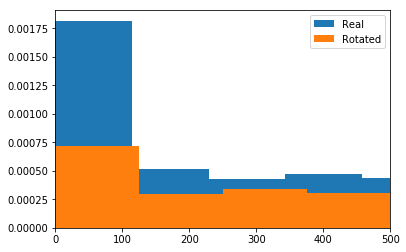

In [136]:
all_distances=[]
for i in range(0,len(df_ecm)):
    all_distances.append(df_ecm["distances to nearest endosome boundary [nms]"][i])
flat_list = []
for sublist in all_distances:
    for item in sublist:
        flat_list.append(item)
all_distances=np.array(flat_list)

all_distances_rot=[]
for i in range(0,len(df_ecm)):
    all_distances_rot.append(df_ecm["rotated - distances to nearest endosome boundary [nms]"][i])
flat_list = []
for sublist in all_distances_rot:
    for item in sublist:
        flat_list.append(item)
all_distances_rot=np.array(flat_list)

plt.figure()
plt.hist(all_distances,density=True,bins=200)
plt.hist(all_distances_rot,density=True,bins=200)
plt.legend(['Real','Rotated'])
plt.xlim([0,500])

## Add protein labels to df

In [137]:
df_ecm['Protein']='None'
df_ecm.loc[(df_ecm['exp condition'].str.contains('nt'))&(df_ecm['exp condition'].str.contains('12')), 'Protein'] = 'Int1b, all TNR Blk+12, stripped'
df_ecm.loc[(df_ecm['exp condition'].str.contains('nt'))&(df_ecm['exp condition'].str.contains('surface')), 'Protein'] = 'Int1b Blk/TNR Blk, +0, surface'
df_ecm.loc[df_ecm['exp condition'].str.contains('tgn'), 'Protein'] = 'TGN38/ TNR Blk, +12'
df_ecm.loc[df_ecm['exp condition'].str.contains('rab'), 'Protein'] = 'Rab11a/ TNR Blk, +12'
df_ecm.loc[df_ecm['exp condition'].str.contains('cav'), 'Protein'] = 'Cav1/ TNR Blk'
df_ecm.loc[df_ecm['exp condition'].str.contains('negctrl'), 'Protein'] = 'Neg ctrl vAchT'
df_ecm.loc[df_ecm['exp condition'].str.contains('positivecontrol'), 'Protein'] = 'Pos ctrl 2 secondaries'

## Dictionary of spots

In [138]:
spots_list={"filename":[],"expname":[],"Protein":[],"distance to nearest endosome boundary [nms]":[],
            "rotated - distance to nearest endosome boundary [nms]":[]}

for i in range(0,len(df_ecm)):
    nospots=len(df_ecm["distances to nearest endosome boundary [nms]"][i])
    protein=df_ecm["Protein"][i]
    file=df_ecm["filename"][i]
    exp=df_ecm["exp condition"][i]
    for spot in range(0,nospots):
        spots_list["filename"].append(file)
        spots_list["expname"].append(exp)
        spots_list["Protein"].append(protein)
        spots_list["distance to nearest endosome boundary [nms]"].append(
            df_ecm["distances to nearest endosome boundary [nms]"][i][spot][0])
        spots_list["rotated - distance to nearest endosome boundary [nms]"].append(
            df_ecm["rotated - distances to nearest endosome boundary [nms]"][i][spot][0])
        
dfspots=pd.DataFrame(spots_list)

## Plot: histograms for all proteins except pos control, same axis

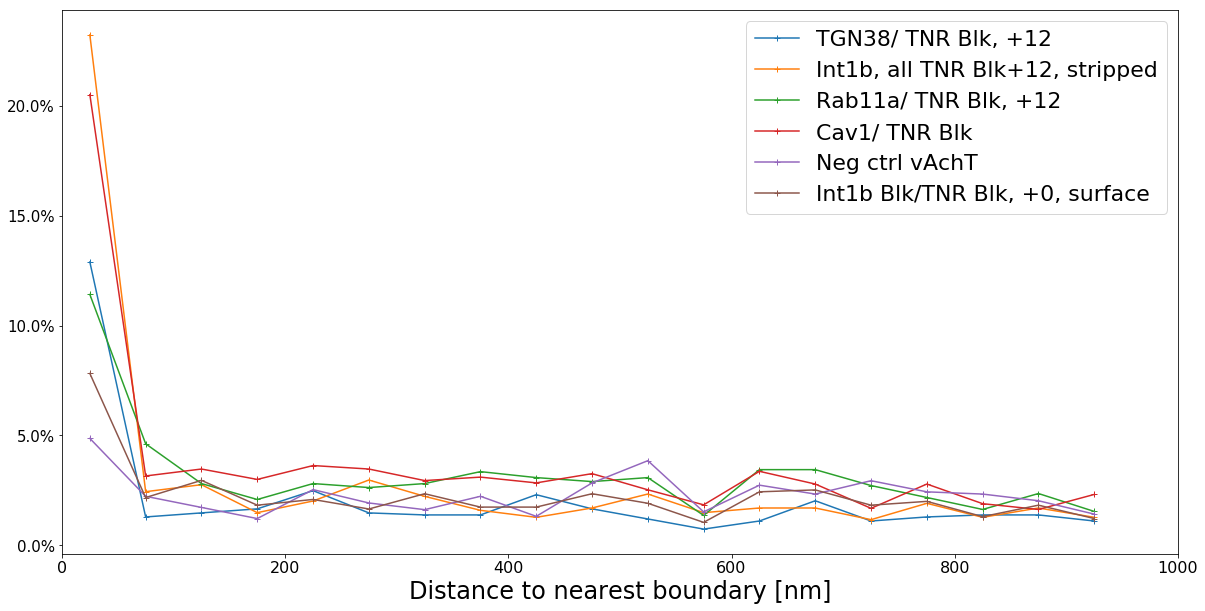

In [58]:
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter
proteins=[]
fig=plt.figure(figsize=(20,10))
df2=deepcopy(dfspots)
df2=df2[df2["Protein"]!="Pos ctrl 2 secondaries"]

for protein in df2["Protein"].unique():
    df2plot=df2[df2["Protein"]==protein]
    proteins.append(protein)
    p=fig.add_subplot(111)
    data=df2plot["distance to nearest endosome boundary [nms]"]
    y,binEdges=np.histogram(data,bins=np.arange(0,1000,50),
                           weights=np.ones(len(data)) / len(data))
                           #density=True)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    p.plot(bincenters,y,'+-')
    
    
    
    #plt.title(protein+" no spots: "+str(len(df2)))
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    #plt.ylim([0,0.03])
    #scale_y=1/100
    #ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
    #p.yaxis.set_major_formatter(ticks_y)
    plt.xlim([0,1000])
    plt.legend(proteins,fontsize=22)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=15)
    plt.xlabel('Distance to nearest boundary [nm]',fontsize=24)
    

## Plot: histogram for all proteins different axis, with rotated histogram

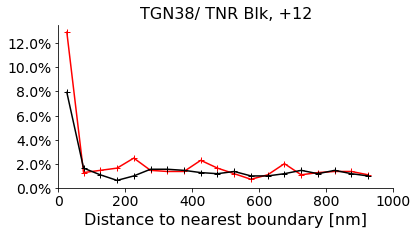

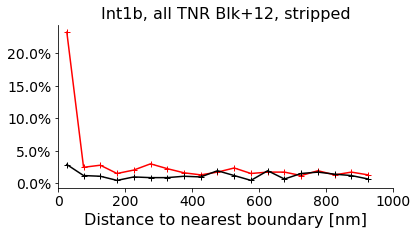

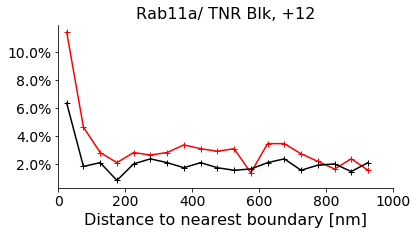

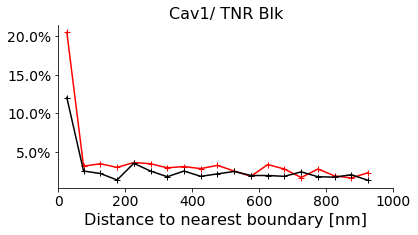

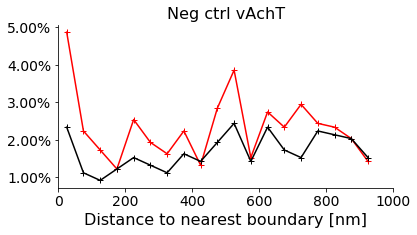

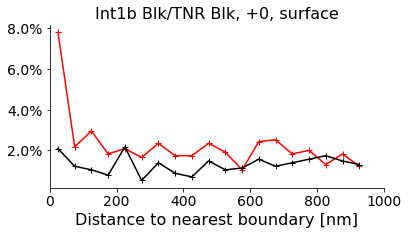

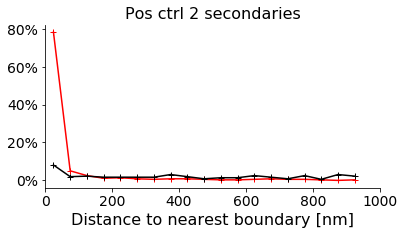

In [139]:
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter
proteins=[]
df2=deepcopy(dfspots)
#df2=df2[df2["Protein"]!="Pos ctrl 2 secondaries"]

for protein in df2["Protein"].unique():
    df2plot=df2[df2["Protein"]==protein]
    proteins.append(protein)
    fig=plt.figure(figsize=(6,3))
    ax=fig.add_subplot(111)
    
    data=df2plot["distance to nearest endosome boundary [nms]"]
    y,binEdges=np.histogram(data,bins=np.arange(0,1000,50),
                           weights=np.ones(len(data)) / len(data))
                           #density=True)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    ax.plot(bincenters,y,'+-',color='red')
    
    data=df2plot["rotated - distance to nearest endosome boundary [nms]"]
    y,binEdges=np.histogram(data,bins=np.arange(0,1000,50),
                           weights=np.ones(len(data)) / len(data))
                           #density=True)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    ax.plot(bincenters,y,'+-',color='black')
    
    
    
    #plt.title(protein+" no spots: "+str(len(df2)))
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    #plt.ylim([0,0.03])
    #scale_y=1/100
    #ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
    #p.yaxis.set_major_formatter(ticks_y)
    plt.xlim([0,1000])
    plt.title(protein,fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Distance to nearest boundary [nm]',fontsize=16)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    

In [1]:
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter
proteins=[]
fig=plt.figure(figsize=(20,10))
df2=deepcopy(dfspots)
df2=df2[df2["Protein"]=="Pos ctrl 2 secondaries"]

for protein in df2["Protein"].unique():
    df2plot=df2[df2["Protein"]==protein]
    proteins.append(protein)
    p=fig.add_subplot(111)
    data=df2plot["distance to nearest endosome boundary [nms]"]
    y,binEdges=np.histogram(data,bins=np.arange(0,1000,50),
                           weights=np.ones(len(data)) / len(data))
                           #density=True)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    p.plot(bincenters,y,'+-')
    
    
    
    #plt.title(protein+" no spots: "+str(len(df2)))
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    #plt.ylim([0,0.03])
    #scale_y=1/100
    #ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
    #p.yaxis.set_major_formatter(ticks_y)
    plt.xlim([0,1000])
    plt.legend(proteins,fontsize=22)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=15)
    plt.xlabel('Distance to nearest boundary [nm]',fontsize=24)
    

NameError: name 'plt' is not defined

(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,
         7000.]), <a list of 9 Text xticklabel objects>)

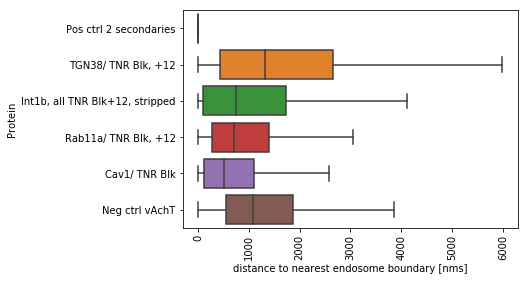

In [225]:
order=["Pos ctrl 2 secondaries",'TGN38/ TNR Blk, +12',
 'Int1b, all TNR Blk+12, stripped',
 'Rab11a/ TNR Blk, +12',
 'Cav1/ TNR Blk','Neg ctrl vAchT']
plt.figure()
sns.boxplot(y="Protein",x="distance to nearest endosome boundary [nms]",data=dfspots,showfliers=False,
              order=order)
plt.xticks(rotation=90)
#plt.xlim([0,5000])

## Real versus rotated - min distance in each image, per protein

## Real vs rot - percent under 50nm distance

In [160]:
#spots dictionary
proteinl=[]
percentunderl=[]
nanometers=50
for protein in dfspots["Protein"].unique():
    df2plot=dfspots[dfspots["Protein"]==protein]
    percent_under=np.sum(df2plot["distance to nearest endosome boundary [nms]"]<50)/len(df2plot["distance to nearest endosome boundary [nms]"])
    proteinl.append(protein)
    percentunderl.append(percent_under*100)

In [161]:
for i in range(0,len(proteinl)):
    print(proteinl[i]+": "+str(percentunderl[i]))

TGN38/ TNR Blk, +12: 12.89134438305709
Int1b, all TNR Blk+12, stripped: 23.223753976670203
Rab11a/ TNR Blk, +12: 11.41304347826087
Cav1/ TNR Blk: 20.50473186119874
Neg ctrl vAchT: 4.86322188449848
Int1b Blk/TNR Blk, +0, surface: 7.819287576020852
Pos ctrl 2 secondaries: 78.15126050420169


In [147]:
nanometers=50
df_ecm["df_percentunder"]=df_ecm["distances to nearest endosome boundary [nms]"]
df_ecm["rot_df_percentunder"]=df_ecm["rotated - distances to nearest endosome boundary [nms]"]
for i in range(0,len(df_ecm)):
    df_ecm["df_percentunder"][i]=np.sum(
        np.array(df_ecm["distances to nearest endosome boundary [nms]"][i])<nanometers)/len(df_ecm["distances to nearest endosome boundary [nms]"][i])*100
    df_ecm["rot_df_percentunder"][i]=np.sum(
        np.array(df_ecm["rotated - distances to nearest endosome boundary [nms]"][i])<nanometers)/len(df_ecm["rotated - distances to nearest endosome boundary [nms]"][i])*100
    
df_ecm["df_percentunder"]=df_ecm["df_percentunder"].astype(float)
df_ecm["rot_df_percentunder"]=df_ecm["rot_df_percentunder"].astype(float)

In [148]:
df_ecm["real minus rot"]=df_ecm["df_percentunder"]-df_ecm["rot_df_percentunder"]

In [153]:
df_ecm.loc[df_ecm["real minus rot"]<0,"real minus rot"]=0

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

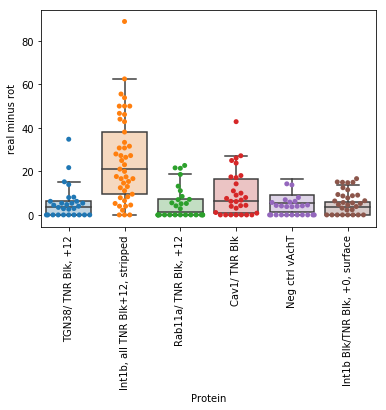

In [154]:
df2plot=df_ecm[df_ecm["Protein"]!="Pos ctrl 2 secondaries"]
order=['TGN38/ TNR Blk, +12', 'Int1b, all TNR Blk+12, stripped',
       'Rab11a/ TNR Blk, +12', 'Cav1/ TNR Blk', 
       'Int1b Blk/TNR Blk, +0, surface','Neg ctrl vAchT']
plt.figure()
g=sns.boxplot(x="Protein",y="real minus rot",data=df2plot,showfliers=False,order=order)
            #showfliers=False)
for patch in g.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
sns.swarmplot(x="Protein",y="real minus rot",data=df2plot)

        #showfliers=False)
plt.xticks(rotation=90)



(0, 60)

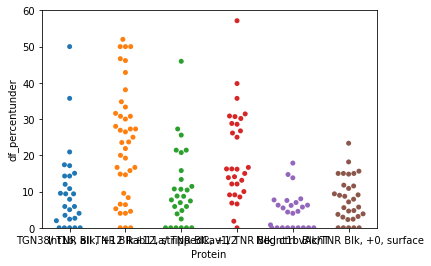

In [157]:
for exp in df_ecm["expname"].unique():
    dfexp=df_ecm[df_ecm["expname"]==exp]
    

In [238]:
df_ecm["expname"].unique()

array(['20190612', '20190523', '20190605', '20190515', '20190522',
       '20190526', '20190611', '20190505', '20190627'], dtype=object)

In [222]:
nanometers=50
Proteins=[]
Percent=[]
for protein in df_ecm["Protein"].unique():
    dfprot=df_ecm[df_ecm["Protein"]==protein]
    for exp in dfprot["expname"].unique():
        Proteins.append(protein)
        dfprotexp=dfprot[dfprot["expname"]==exp]
        percentreal=np.mean(dfprotexp["df_percentunder"])
        percentrot=np.mean(dfprotexp["rot_df_percentunder"])
        Percent.append(percentreal)
    
        

In [239]:
nanometers=100
Proteins=[]
Percent=[]
for protein in dfspots["Protein"].unique():
    dfprot=dfspots[dfspots["Protein"]==protein]
    for exp in dfprot["expname"].unique():
        dfprotexp=dfprot[dfprot["expname"]==exp]
        Proteins.append(protein)
        percentreal=np.sum(np.array(dfprotexp["distance to nearest endosome boundary [nms]"]
                                <nanometers))/len(dfprotexp["distance to nearest endosome boundary [nms]"])*100
        percentrot=np.sum(np.array(dfprotexp["rotated - distance to nearest endosome boundary [nms]"]
                                <nanometers))/len(dfprotexp["rotated - distance to nearest endosome boundary [nms]"])*100
        
        Percent.append(percentreal/percentrot)
    
        

In [221]:
df_ecm["expname"]=df_ecm["exp condition"]
for i in range(0,len(df_ecm)):
    df_ecm["expname"][i]=df_ecm["exp condition"][i][0:8]

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

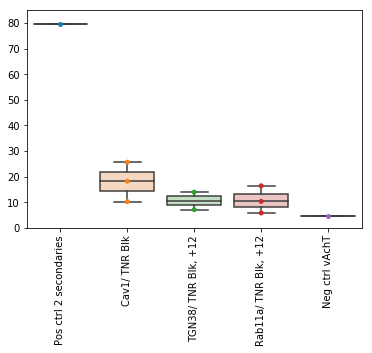

In [236]:
order=['Pos ctrl 2 secondaries','Cav1/ TNR Blk','TGN38/ TNR Blk, +12', 
       'Rab11a/ TNR Blk, +12','Neg ctrl vAchT']
g=sns.boxplot(x=Proteins,y=Percent,order=order)
sns.swarmplot(x=Proteins,y=Percent,order=order)
for patch in g.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
plt.ylim(0,85)
plt.xticks(rotation=90)



(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

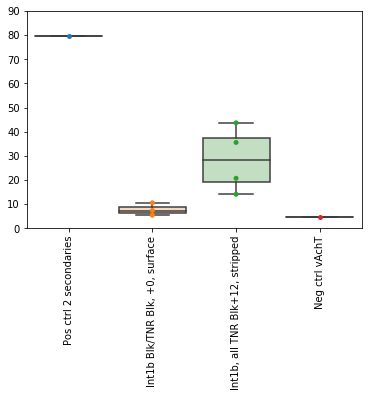

In [237]:
order=['Pos ctrl 2 secondaries', 'Int1b Blk/TNR Blk, +0, surface',
       'Int1b, all TNR Blk+12, stripped','Neg ctrl vAchT']
g=sns.boxplot(x=Proteins,y=Percent,order=order)
sns.swarmplot(x=Proteins,y=Percent,order=order)
for patch in g.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
plt.ylim(0,90)
plt.xticks(rotation=90)




##### combine into a single dataframe with rotated or real as a category

In [61]:
df_ecm_copy=deepcopy(df_ecm)
df_ecm_copy["percent_under"]=df_ecm_copy["df_percentunder"]
df_ecm_copy["Real or rot"]="Real"
df_ecm_copy2=deepcopy(df_ecm)
df_ecm_copy2["percent_under"]=df_ecm_copy["rot_df_percentunder"]
df_ecm_copy2["Real or rot"]="Rotated"
df_merged=df_ecm_copy.append(df_ecm_copy2)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

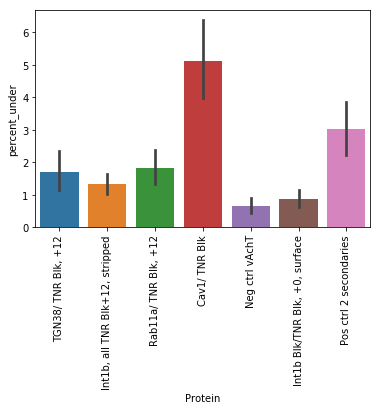

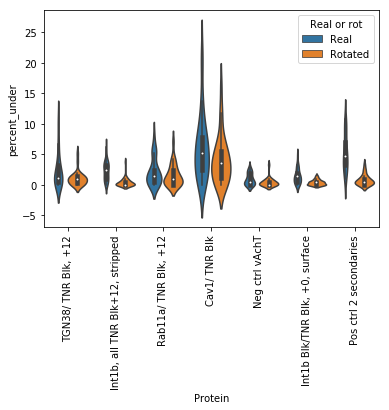

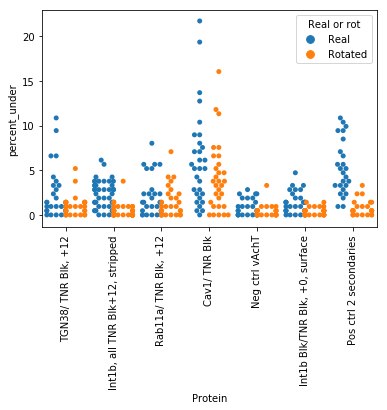

In [68]:
plt.figure()
sns.barplot(x="Protein",y="percent_under",data=df_merged)
            #showfliers=False)
plt.xticks(rotation=90)

plt.figure()
sns.violinplot(x="Protein",y="percent_under",data=df_merged,hue="Real or rot")
plt.xticks(rotation=90)

plt.figure()
sns.swarmplot(x="Protein",y="percent_under",data=df_merged,hue="Real or rot",dodge=True)
plt.xticks(rotation=90)

In [ ]:
#spots dictionary


## Find representative images for each condition

In [ ]:
df2show.columns

In [ ]:
df_originaldata=pd.DataFrame(results)
df_originaldata['Protein']='None'
df_originaldata.loc[(df_originaldata['exp condition'].str.contains('nt'))&(df_originaldata['exp condition'].str.contains('12')), 'Protein'] = 'Int1b, all TNR Blk+12, stripped'
df_originaldata.loc[(df_originaldata['exp condition'].str.contains('nt'))&(df_originaldata['exp condition'].str.contains('surface')), 'Protein'] = 'Int1b Blk/TNR Blk, +0, surface'
df_originaldata.loc[df_originaldata['exp condition'].str.contains('tgn'), 'Protein'] = 'TGN38/ TNR Blk, +12'
df_originaldata.loc[df_originaldata['exp condition'].str.contains('rab'), 'Protein'] = 'Rab11a/ TNR Blk, +12'
df_originaldata.loc[df_originaldata['exp condition'].str.contains('cav'), 'Protein'] = 'Cav1/ TNR Blk'

In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')


protein='TGN38/ TNR Blk, +12'

df2show=df_originaldata[df_originaldata["Protein"]==protein]

for image in range(0,len(df2show)):
    ecm_channel_no=df_originaldata["ecmchannelno"][image]
    endosome_channel_no=df_originaldata["endosomechannelno"][image]
    ecm_image_name=df_originaldata["filename"][image]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
    endosome_image_name=df_originaldata["filename"][image]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"
    ecm_image=pims.open(ecm_image_name)[0]
    endosome_image=pims.open(endosome_image_name)[0]
    fig=plt.figure(figsize=(9,3))
    fig.add_subplot(131)
    plt.imshow(ecm_image,cmap='viridis',vmin=0.2*np.mean(ecm_image),vmax=0.8*np.max(ecm_image))
    plt.axis(show=False)
    plt.title('TNR', fontsize=14)
    fig.add_subplot(132)
    plt.imshow(endosome_image,cmap='viridis',vmin=0.2*np.mean(endosome_image),vmax=0.8*np.max(endosome_image))
    plt.axis(show=False)
    plt.title(protein, fontsize=14)
    plt.tight_layout()

In [ ]:
results.keys()